In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")
from scipy.stats import chisquare

## Hits where antibiotic resistance evolves first
#### Exclude hits with two non-related antibiotics -> these go in co-linearity section

In [2]:
# Merge sequential and simultaneous hits into a single table

all_hits_sequential = pd.read_csv("output/04A.pair_annotation/results_allpairs_annotation_withcategories.csv", index_col=0)
all_simultaneous = pd.read_csv("output/04B.pair_annotation/results_allpairs_annotation_withcategories.csv", index_col=0)

sequential_merged = all_hits_sequential.merge(all_simultaneous[["position_i", "position_j", "pval_beta_i_on_j", 'pval_beta_i_on_j_BH_sig']], 
                                                on=["position_i", "position_j"], how="left", suffixes=["_sequential", "_simultaneous"])

simultaneous_merged = all_simultaneous.merge(all_hits_sequential[["position_i", "position_j", "pval_beta_i_on_j", 'pval_beta_i_on_j_BH_sig']], 
                                                on=["position_i", "position_j"], how="left", suffixes=[ "_simultaneous", "_sequential"])

all_hits = pd.concat([simultaneous_merged, sequential_merged])
all_hits = all_hits.drop_duplicates(subset=["position_i", "position_j"]).reset_index(drop=True)



In [3]:
known_antibiotic_first = all_hits.dropna(subset=["known_drug_j"]).query("pval_beta_i_on_j_BH_sig_sequential or pval_beta_i_on_j_BH_sig_simultaneous")

known_antibiotic_first['num_dependent'] = known_antibiotic_first.n_muts_i_on_branch_j + known_antibiotic_first.n_muts_same_branch
know_ab_first = known_antibiotic_first.loc[known_antibiotic_first.possible_drug_i.isnull(), :]
know_ab_first.sort_values('num_dependent', ascending=False).head(40)

,Unnamed: 0.1,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,...,in_antigen_epitope_j,in_antigen_protein_j,in_known_ABR_position_j,known_drug_j,in_possible_ABR_gene_j,possible_drug_j,annotation,pval_beta_i_on_j_sequential,pval_beta_i_on_j_BH_sig_sequential,num_dependent
50060,184,1673425,r_fabG1,2155168,katG,752,1811,3817,12564,121,...,False,True,True,"INH,INH,INH,INH,INH",True,INH,between_known_AB,9.910234e-01,False,174
49891,1,105060,Rv0095c,2155168,katG,345,1811,4492,12564,61,...,False,True,True,"INH,INH,INH,INH,INH",True,INH,known_AB_first,8.507087e-01,False,91
50441,596,105063,Rv0095c,2155168,katG,333,1811,4418,12564,60,...,False,True,True,"INH,INH,INH,INH,INH",True,INH,known_AB_first,7.991665e-01,False,89
51249,1453,1673425,r_fabG1,4247429,embB,752,819,3817,2866,20,...,False,False,True,"EMB,EMB,EMB",True,EMB,between_known_AB,9.817820e-01,False,80
50430,585,1164571,None,2155168,katG,343,1811,14710,12564,46,...,False,True,True,"INH,INH,INH,INH,INH",True,INH,known_AB_first,9.999372e-01,False,80
52502,2764,1673425,r_fabG1,4247431,embB,752,791,3817,2090,14,...,False,False,True,"EMB,EMB,EMB",True,EMB,between_known_AB,9.742324e-01,False,71
710727,442495,2986827,Rv2670c,2155168,katG,95,1811,671,12564,41,...,False,True,True,"INH,INH,INH,INH,INH",True,INH,known_AB_first,2.983030e-10,True,70
50283,424,401678,Rv0336,2155168,katG,301,1811,3064,12564,38,...,False,True,True,"INH,INH,INH,INH,INH",True,INH,known_AB_first,9.999447e-01,False,68
50378,526,2123145,lldD2,2155168,katG,301,1811,3348,12564,37,...,False,True,True,"INH,INH,INH,INH,INH",True,INH,known_AB_first,9.999715e-01,False,63
710484,442174,3067961,r_thyX,2155168,katG,78,1811,286,12564,29,...,False,True,True,"INH,INH,INH,INH,INH",True,INH,known_AB_first,2.200279e-05,True,53


In [4]:
def _process_known_hits(input_list):
    """
    splits the possible associated drugs (string separated by ,) into a list
    """
    output_list = []
    for item in input_list:
        #print(item)
        if type(item) != str:
            output_list.append(np.nan)
        else:
            splitted = item.split(",")
            exclusive= list(set(splitted))
            output_list.append(exclusive)
    return output_list

known_antibiotic_first = all_hits.dropna(subset=["known_drug_j"]).query("pval_beta_i_on_j_BH_sig_sequential or pval_beta_i_on_j_BH_sig_simultaneous")

known_antibiotic_first["known_drug_i"] = _process_known_hits(known_antibiotic_first.known_drug_i)
known_antibiotic_first["possible_drug_i"] = _process_known_hits(known_antibiotic_first.possible_drug_i)

known_antibiotic_first["known_drug_j"] = _process_known_hits(known_antibiotic_first.known_drug_j)
known_antibiotic_first["possible_drug_j"] = _process_known_hits(known_antibiotic_first.possible_drug_j)

print(len(known_antibiotic_first))

2043


In [5]:
between_antibiotic_indices = []
antibiotic_indices = []

known_antibiotic_first["within_same_drug"] = False

for idx, row in known_antibiotic_first.iterrows():
    
    set_of_known_first = set(row.known_drug_j)
    set_of_known_second = set()
    known_drug_second = False
    
    if type(row.known_drug_i) is list:
        set_of_known_second= set(row.known_drug_i)
        known_drug_second = True
        
    elif type(row.possible_drug_i) is list:
        set_of_known_second= set(row.possible_drug_i)
        known_drug_second = True
        
    if not known_drug_second:
        antibiotic_indices.append(idx)
    
    elif len(set_of_known_first.intersection(set_of_known_second)) > 0:
        antibiotic_indices.append(idx)
        known_antibiotic_first.loc[idx, "within_same_drug"] = True
        
    else:
        between_antibiotic_indices.append(idx)
        
between_antibiotic_hits = known_antibiotic_first.loc[between_antibiotic_indices]
antibiotic_hits = known_antibiotic_first.loc[antibiotic_indices]
    

In [6]:
!mkdir output/05.antibiotic
antibiotic_hits.to_csv("output/05.antibiotic/antibiotic_hits.csv")
between_antibiotic_hits.to_csv("output/05.antibiotic/between_antibiotic_hits.csv")
all_hits.to_csv("output/05.antibiotic/all_pairs.csv")

mkdir: cannot create directory ‘output/04.antibiotic’: File exists


## Compute per-drug output tables

In [7]:
## These will contain all hits except the between-antibiotic hits

## First get the list of all names of drugs in the dataset
drug_list = []
for idx, row in antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1 + drugs2:
        drug_list.append(drug)

drug_list = list(set(drug_list))

## Then create an empty df for each
df_dict = {drug:pd.DataFrame() for drug in drug_list}

## now concatenate each row to the appropriate drug dataframe
for idx, row in antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1:
        df_dict[drug] = df_dict[drug].append(row)
        
    for drug in drugs2:
        df_dict[drug] = df_dict[drug].append(row)
        
for drug, df in df_dict.items():
    print(drug, len(df))
    df.sort_values("n_muts_i_on_branch_j", ascending=False).to_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv")
    df.query("pval_beta_i_on_j_BH_sig_sequential != 0").query("pval_beta_i_on_j_BH_sig_sequential").sort_values(
        "n_muts_i_on_branch_j", ascending=False
    ).to_csv(f"output/05.antibiotic/{drug}_antibiotic_hits_sequential.csv")

RIF 152
KAN 101
EMB 273
MXF 15
LZD 68
LEV 15
AMI 101
ETH 45
PZA 129
CAP 67
STM 216
INH 173


In [8]:
df

,Unnamed: 0.1,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,...,in_antigen_epitope_j,in_antigen_protein_j,in_known_ABR_position_j,known_drug_j,in_possible_ABR_gene_j,possible_drug_j,annotation,pval_beta_i_on_j_sequential,pval_beta_i_on_j_BH_sig_sequential,within_same_drug
49891,1.0,105060.0,Rv0095c,2155168.0,katG,345.0,1811.0,4492.0,12564.0,61.0,...,0.0,1.0,1.0,[INH],1.0,[INH],known_AB_first,8.507087e-01,0.0,0.0
49893,3.0,1341099.0,esxL,2155168.0,katG,194.0,1811.0,3398.0,12564.0,29.0,...,False,True,True,[INH],True,[INH],known_AB_first,9.815673e-01,False,False
49904,14.0,332726.0,vapC25,2155168.0,katG,65.0,1811.0,604.0,12564.0,8.0,...,False,True,True,[INH],True,[INH],known_AB_first,9.738677e-01,False,False
49906,18.0,1339741.0,PPE18,2155168.0,katG,161.0,1811.0,6850.0,12564.0,28.0,...,False,True,True,[INH],True,[INH],known_AB_first,8.633712e-01,False,False
49911,23.0,332735.0,vapC25,2155168.0,katG,71.0,1811.0,654.0,12564.0,9.0,...,False,True,True,[INH],True,[INH],known_AB_first,9.729714e-01,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719789,512119.0,3926792.0,PE_PGRS53,2155167.0,katG,7.0,56.0,2.0,136.0,2.0,...,False,True,True,[INH],True,[INH],known_AB_first,5.709967e-05,True,False
719804,512146.0,3108690.0,Rv2800,2155167.0,katG,8.0,56.0,4.0,136.0,2.0,...,False,True,True,[INH],True,[INH],known_AB_first,8.211266e-05,True,False
756716,905828.0,2154083.0,katG,1673425.0,r_fabG1,7.0,752.0,0.0,3817.0,5.0,...,False,False,True,"[INH, ETH]",False,NaN,known_AB_first,2.697028e-07,True,True
773611,1270695.0,3268906.0,ppsE,1674481.0,inhA,8.0,78.0,12.0,360.0,4.0,...,False,True,True,[ETH],True,"[INH, ETH]",known_AB_first,1.002520e-08,True,False


In [11]:
## These will contain all hits except the between-antibiotic hits

## First get the list of all names of drugs in the dataset
drug_list = []
for idx, row in between_antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1 + drugs2:
        drug_list.append(drug)

drug_list = list(set(drug_list))

## Then create an empty df for each
df_dict = {drug:pd.DataFrame() for drug in drug_list}

## now concatenate each row to the appropriate drug dataframe
for idx, row in between_antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1:
        df_dict[drug] = df_dict[drug].append(row)
        
    for drug in drugs2:
        df_dict[drug] = df_dict[drug].append(row)
        
for drug, df in df_dict.items():
    print(drug, len(df))
    df.sort_values("n_muts_i_on_branch_j", ascending=False).to_csv(f"output/05.antibiotic/{drug}_between_antibiotic_hits.csv")

RIF 465
KAN 227
EMB 418
MXF 153
LZD 153
LEV 153
AMI 227
ETH 65
CFZ 2
PZA 334
CAP 153
STM 317
INH 205
BDQ 2


## Fraction of resistant strains with a dependent mutation

In [12]:
# Here let strains with a resistance-conferring mutation be defined as resistant
# Then count the number of resistant strains that have another mutation

snps = pd.read_csv("output/05.single_mutations/snps_with_all_annotation.csv", index_col=0)
snps = snps.query("not is_lineage")

# list of resistance mutations
resistance_mutations = snps.query("in_known_ABR_position")
resistance_mutations["known_drug"] = _process_known_hits(resistance_mutations.known_drug)

antibiotic_hits = antibiotic_hits.query("pval_beta_i_on_j_BH_sig_sequential")
print(len(antibiotic_hits))
# list of all other mutations
other_positions = list(set(antibiotic_hits.position_i))
other_mutations = snps.query("pos in @other_positions")



561


In [13]:
# # Read in the matrix of isolate x genotype
# # Input information from Roger
genotype_translator = {
0:"A", 1:"C", 2:"G", 3:"T", 9:"N"
}
isolate_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl"
genotype_array_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy"
snp_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl"
genotype_translator_r = {y:x for x,y in genotype_translator.items()}

isolates = pd.read_pickle(isolate_annotation_file)
genotypes = np.load(genotype_array_file)
snps_older = pd.read_pickle(snp_annotation_file)
# # Filter out the snps we don't need
snps_to_retain = snps_older.query("pos in @other_positions or pos in @resistance_mutations.pos")
indices_to_keep = snps_to_retain.index

g = genotypes[indices_to_keep, :]
del genotypes
np.save("output/05.antibiotic/antibiotic_genotypes_matrix.npy", g)
g = np.load("output/05.antibiotic/antibiotic_genotypes_matrix.npy")

In [14]:
snps_to_retain = snps_to_retain.reset_index()

In [15]:
# For each drug, get the set of mutations we are looking for
drug_to_sensitive_sites = {drug:[] for drug in drug_list}
for idx, row in resistance_mutations.iterrows():
    for drug in row.known_drug:
        drug_to_sensitive_sites[drug].append((row.pos, row.ref))

# Find strains that have any of those mutations
drug_to_indices_R_strains = {}

_num_sequential_dependencies = []
for drug, list_of_tuples in drug_to_sensitive_sites.items():
    
    has_sensitive_alleles = np.ones(shape=(len(list_of_tuples), g.shape[1]))
    #print(drug)
    
    for idx, (pos, nt) in enumerate(list_of_tuples):
    
        matrix_index = snps_to_retain.query("pos==@pos").index
        has_sensitive_alleles[idx,:] = g[matrix_index, :] == genotype_translator_r[nt]
        
    #print(np.sum(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0]))
    indices_R_strains = np.where(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0])[0]
    drug_to_indices_R_strains[drug] = indices_R_strains
    
    try:
        drug_specific_dependencies = pd.read_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv", index_col=0)
    except:
        print("no file for", drug)
        continue
    drug_specific_dependencies = drug_specific_dependencies.query("pval_beta_i_on_j_BH_sig_sequential == 'True'")
    
    # Get the dependent positions - exclude any known resistance mutation from dependent sites
    dependent_positions = set(drug_specific_dependencies.position_i) - set(resistance_mutations.pos)
    dependencies = snps_to_retain.query("pos in @dependent_positions")
    #print(drug, "has", len(dependencies), "dependencies excluding known R positions")
    assert(len(dependent_positions) == len(dependencies))
    
    # Create a matrix of which strains have a dependent mutation
    _dependency_df = []
    has_dependent_alleles = np.ones(shape=(len(dependencies), len(indices_R_strains)))
    for mat_idx, (idx, row) in enumerate(dependencies.iterrows()):
        has_dependency = g[:, indices_R_strains][idx, :] != genotype_translator_r[row.ref]
        total_has_dependency = g[idx, :] != genotype_translator_r[row.ref]
        _dependency_df.append([idx, row.pos, row.ref, np.sum(has_dependency), np.sum(total_has_dependency)])
        has_dependent_alleles[mat_idx, :] = has_dependency
    
    dependency_df = pd.DataFrame(_dependency_df, columns=["matrix_idx", "pos", "ref", "num_R_strains_with_dependency", "total_strains_with_mutation"])
    dependency_df.to_csv(f"output/05.antibiotic/strains_with_dependencies_per_AB/{drug}.csv")
    
    _num_sequential_dependencies.append([drug, len(indices_R_strains), np.sum(np.sum(has_dependent_alleles, axis=0) > 0)])

df = pd.DataFrame(_num_sequential_dependencies, columns=["drug", "num_R_strains", "num_R_strains_with_dependency"])
df["fraction"] = df.num_R_strains_with_dependency / df.num_R_strains
df.to_csv("output/05.antibiotic/num_strains_with_dependency.csv")    
df

no file for CFZ
no file for BDQ


,drug,num_R_strains,num_R_strains_with_dependency,fraction
0,RIF,10083,5092,0.505008
1,KAN,4410,1916,0.434467
2,EMB,7235,3464,0.478784
3,MXF,3153,297,0.094196
4,LZD,109,53,0.486239
5,LEV,3153,297,0.094196
6,AMI,3431,1394,0.406296
7,ETH,5744,1513,0.263405
8,PZA,9563,3979,0.416083
9,CAP,3194,1153,0.360989


In [21]:
# Here let strains with a resistance-conferring mutation be defined as resistant
# Then count the number of resistant strains that have another mutation
#include simultaenous and sequential

snps = pd.read_csv("output/05.single_mutations/snps_with_all_annotation.csv", index_col=0)
snps = snps.query("not is_lineage")

# list of resistance mutations
resistance_mutations = snps.query("in_known_ABR_position")
resistance_mutations["known_drug"] = _process_known_hits(resistance_mutations.known_drug)
antibiotic_hits = pd.read_csv("output/05.antibiotic/antibiotic_hits.csv")
print(len(antibiotic_hits))
# list of all other mutations
antibiotic_hits["dist"] = np.abs(antibiotic_hits.position_j - antibiotic_hits.position_i)
antibiotic_hits = antibiotic_hits.query("pval_beta_i_on_j_BH_sig_sequential or (pval_beta_i_on_j_BH_sig_simultaneous and dist >100)")
print(len(antibiotic_hits))


1003
993


In [22]:

other_positions = list(set(antibiotic_hits.position_i))
other_mutations = snps.query("pos in @other_positions")

# # Read in the matrix of isolate x genotype
# # Input information from Roger
genotype_translator = {
0:"A", 1:"C", 2:"G", 3:"T", 9:"N"
}
isolate_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl"
genotype_array_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy"
snp_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl"
genotype_translator_r = {y:x for x,y in genotype_translator.items()}

isolates = pd.read_pickle(isolate_annotation_file)
genotypes = np.load(genotype_array_file)
snps_older = pd.read_pickle(snp_annotation_file)
# # Filter out the snps we don't need
snps_to_retain = snps_older.query("pos in @other_positions or pos in @resistance_mutations.pos")
indices_to_keep = snps_to_retain.index

g = genotypes[indices_to_keep, :]
del genotypes
np.save("output/05.antibiotic/antibiotic_genotypes_matrix.npy", g)
g = np.load("output/05.antibiotic/antibiotic_genotypes_matrix.npy")

snps_to_retain = snps_to_retain.reset_index()

In [23]:
# For each drug, get the set of mutations we are looking for
drug_to_sensitive_sites = {drug:[] for drug in drug_list}
for idx, row in resistance_mutations.iterrows():
    for drug in row.known_drug:
        drug_to_sensitive_sites[drug].append((row.pos, row.ref))

# Find strains that have any of those mutations
drug_to_indices_R_strains = {}

_num_sequential_dependencies = []
for drug, list_of_tuples in drug_to_sensitive_sites.items():
    
    has_sensitive_alleles = np.ones(shape=(len(list_of_tuples), g.shape[1]))
    #print(drug)
    
    # Determine if each isolate has any sensitive allele
    for idx, (pos, nt) in enumerate(list_of_tuples):
    
        matrix_index = snps_to_retain.query("pos==@pos").index
        has_sensitive_alleles[idx,:] = g[matrix_index, :] == genotype_translator_r[nt]
        
    #print(np.sum(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0]))
    indices_R_strains = np.where(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0])[0]
    drug_to_indices_R_strains[drug] = indices_R_strains
    
    try:
        drug_specific_dependencies = pd.read_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv", index_col=0)
    except:
        print("no file for", drug)
        continue
    #drug_specific_dependencies = drug_specific_dependencies.query("pval_beta_i_on_j_BH_sig_sequential == 'True'")
    
    # Get the dependent positions - exclude any known resistance mutation from dependent sites
    dependent_positions = set(drug_specific_dependencies.position_i) - set(resistance_mutations.pos)
    dependencies = snps_to_retain.query("pos in @dependent_positions")
    #print(drug, "has", len(dependencies), "dependencies excluding known R positions")
    assert(len(dependent_positions) == len(dependencies))
    
    # Create a matrix of which strains have a dependent mutation
    _dependency_df = []
    has_dependent_alleles = np.ones(shape=(len(dependencies), len(indices_R_strains)))
    for mat_idx, (idx, row) in enumerate(dependencies.iterrows()):
        has_dependency = g[:, indices_R_strains][idx, :] != genotype_translator_r[row.ref]
        total_has_dependency = g[idx, :] != genotype_translator_r[row.ref]
        _dependency_df.append([idx, row.pos, row.ref, np.sum(has_dependency), np.sum(total_has_dependency)])
        has_dependent_alleles[mat_idx, :] = has_dependency
    
    dependency_df = pd.DataFrame(_dependency_df, columns=["matrix_idx", "pos", "ref", "num_R_strains_with_dependency", "total_strains_with_mutation"])
    dependency_df.to_csv(f"output/05.antibiotic/strains_with_dependencies_per_AB/{drug}.csv")
    
    _num_sequential_dependencies.append([drug, len(indices_R_strains), np.sum(np.sum(has_dependent_alleles, axis=0) > 0)])
    
df = pd.DataFrame(_num_sequential_dependencies, columns=["drug", "num_R_strains", "num_R_strains_with_dependency"])
df["fraction"] = df.num_R_strains_with_dependency / df.num_R_strains
df.to_csv("output/05.antibiotic/num_strains_with_dependency_simultaneous.csv")    


no file for CFZ
no file for BDQ


### Plot fraction of resistant strains with a dependent mutation

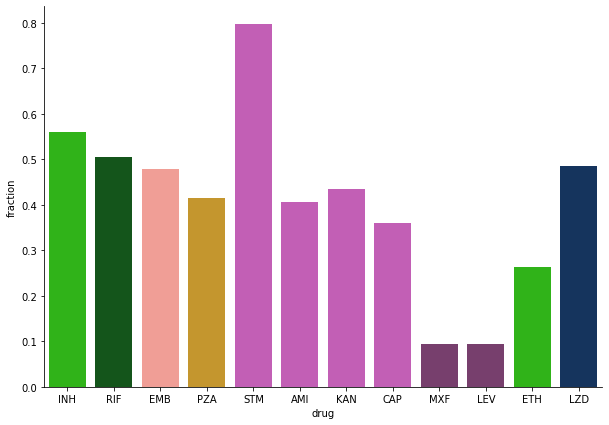

In [26]:
list_of_colors = [
    (30, 204, 0),
    (9, 96, 19),
    (255, 146, 135),
    (221, 160, 21),
    (210,78,193),
    (210,78,193),
    (210,78,193),
    
    (210,78,193),
    
    (128,54,115),
    (128,54,115),
    (30,204,0),
    (9, 50, 105),
    
    (128,54,115),
    (128,54,115),
    (128,54,115),
    (128,54,115),
    (139,192,221),
    (9, 50, 105),

    (189,189,189)
]
list_of_colors = [(x/255,y/255, z/255) for x,y,z in list_of_colors]

# Make plot

df_both = pd.read_csv("output/05.antibiotic/num_strains_with_dependency_simultaneous.csv", index_col=0) 
df_single = pd.read_csv("output/05.antibiotic/num_strains_with_dependency.csv", index_col=0)  

df_both["label"]= "both"
df_single["label"] = "sequential_only"

sorted_drug_list = [ 'INH', "RIF", "EMB", "PZA", 
                     'STM', 'AMI','KAN', 'CAP',
                     'MXF', 'LEV', 'ETH',
                    'DLM','CFZ','LZD','BDQ'
]

#df = pd.concat([df_both, df_single])
df = df_single
# Generate a rank column that will be used to sort
# the dataframe numerically
sorterIndex = dict(zip(sorted_drug_list, range(len(sorted_drug_list))))
df['ab_rank'] = df['drug'].map(sorterIndex)
df = df.sort_values("ab_rank")
sns.set_palette(sns.color_palette(list_of_colors))
figure=plt.figure(figsize=(10,7))
sns.barplot(data=df,x="drug", y="fraction", palette= sns.color_palette(list_of_colors))
sns.despine()
plt.savefig("figures/percent_strains_with_dependency.pdf")

## Prepare Cytoscape plot of between-antibiotic dependencies

In [22]:
!mkdir output/05.antibiotic/cytoscape

mkdir: cannot create directory ‘output/04.antibiotic/cytoscape’: File exists


In [45]:
N=1
_p = []

for drug in drug_list: 
    try:
        ab_hits = pd.read_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv", index_col=0).drop_duplicates()
        between_hits = pd.read_csv(f"output/05.antibiotic/{drug}_between_antibiotic_hits.csv", index_col=0).drop_duplicates()
        
        ## ThyX is antibiotic associated
        #ab_hits = ab_hits.query("gene_name_i != 'r_thyX' and gene_name_i != 'r_thyA'")
    except:
        continue

    allhits = ab_hits
    allhits['overlap'] = allhits.n_muts_i_on_branch_j + allhits.n_muts_same_branch
    print(drug, len(allhits))
    
    # filtering
    allhits = allhits.query("overlap > 9")
    
    allhits = allhits.sort_values("overlap", ascending=False)
    p = allhits.head(N)[["position_i", "gene_name_i", "position_j", "gene_name_j", "overlap"]]
    p["drug"] = drug
    print(p)
    _p.append(p)
    
    between_ab = between_hits
    between_ab['overlap'] = between_ab.n_muts_i_on_branch_j + between_ab.n_muts_same_branch
    between_ab = between_ab.sort_values("overlap", ascending=False)
    
    between_ab = between_ab.query("overlap > 9")
    
    p = between_ab.head(N)[["position_i", "gene_name_i", "position_j", "gene_name_j", "overlap"]]
    p["drug"] = drug
    print(p)
    _p.append(p)
    
df = pd.concat(_p)
df = df.reset_index(drop=True)
df.loc[df.query("position_i==3073679").index, "gene_name_i"] = "r_thyA"

df['name_i']=[f'{x}_{y}' for x,y in zip(df.gene_name_i, df.position_i)]
df['name_j']=[f'{x}_{y}' for x,y in zip(df.gene_name_j, df.position_j)]

df.to_csv(f"output/05.antibiotic/cytoscape//top_{N}_hits_per_drug_2022.csv")
df

PZA 119
        position_i gene_name_i  position_j gene_name_j  overlap drug
787637   2277474.0     Rv2030c   2289090.0        pncA      6.0  PZA
        position_i gene_name_i  position_j gene_name_j  overlap drug
710400   2289252.0      r_pncA   2155168.0        katG     87.0  PZA
MXF 12
       position_i gene_name_i  position_j gene_name_j  overlap drug
80779      7570.0        gyrA      7572.0        gyrA      5.0  MXF
       position_i gene_name_i  position_j gene_name_j  overlap drug
49923      7582.0        gyrA   2155168.0        katG    339.0  MXF
LZD 68
        position_i gene_name_i  position_j gene_name_j  overlap drug
681380    781687.0        rpsL   1472362.0         rrs     41.0  LZD
       position_i gene_name_i  position_j gene_name_j  overlap drug
49992   1473246.0         rrs   2155168.0        katG    254.0  LZD
RIF 130
        position_i gene_name_i  position_j gene_name_j  overlap drug
703749    764817.0        rpoC    761155.0        rpoB    183.0  RIF
       pos

,position_i,gene_name_i,position_j,gene_name_j,overlap,drug,name_i,name_j
0,2277474.0,Rv2030c,2289090.0,pncA,6.0,PZA,Rv2030c_2277474.0,pncA_2289090.0
1,2289252.0,r_pncA,2155168.0,katG,87.0,PZA,r_pncA_2289252.0,katG_2155168.0
2,7570.0,gyrA,7572.0,gyrA,5.0,MXF,gyrA_7570.0,gyrA_7572.0
3,7582.0,gyrA,2155168.0,katG,339.0,MXF,gyrA_7582.0,katG_2155168.0
4,781687.0,rpsL,1472362.0,rrs,41.0,LZD,rpsL_781687.0,rrs_1472362.0
5,1473246.0,rrs,2155168.0,katG,254.0,LZD,rrs_1473246.0,katG_2155168.0
6,764817.0,rpoC,761155.0,rpoB,183.0,RIF,rpoC_764817.0,rpoB_761155.0
7,761155.0,rpoB,2155168.0,katG,815.0,RIF,rpoB_761155.0,katG_2155168.0
8,7570.0,gyrA,7572.0,gyrA,5.0,LEV,gyrA_7570.0,gyrA_7572.0
9,7582.0,gyrA,2155168.0,katG,339.0,LEV,gyrA_7582.0,katG_2155168.0


In [46]:
# mutations in same gene or region get condensed

g= df.groupby(["gene_name_i", "gene_name_j"]).agg({
    "overlap":"sum",
    "drug":"max"
})
g["name_i"] = g.index.get_level_values(0)
g["name_j"] = g.index.get_level_values(1)
g.name_i = [x.replace("r_","p_") for x in g.name_i]
g.name_j = [x.replace("r_","p_") for x in g.name_j]
#g["drug"] = [gene_to_ab[x] if x in gene_to_ab else None for x in g.index.get_level_values(0)]

g.to_csv(f"output/05.antibiotic/cytoscape/top_{N}_hits_per_drug_grouped.csv")
g

overlap drug   name_i name_j
gene_name_i gene_name_j                              
Rv2030c     pncA             6.0  PZA  Rv2030c   pncA
embB        embB            41.0  EMB     embB   embB
            katG           454.0  EMB     embB   katG
gyrA        gyrA            10.0  MXF     gyrA   gyrA
            katG           678.0  MXF     gyrA   katG
r_fabG1     inhA            27.0  ETH  p_fabG1   inhA
            katG           174.0  INH  p_fabG1   katG
r_pncA      katG            87.0  PZA   p_pncA   katG
rpoB        inhA            26.0  ETH     rpoB   inhA
            katG          1630.0  RIF     rpoB   katG
rpoC        rpoB           183.0  RIF     rpoC   rpoB
rpsL        katG           434.0  STM     rpsL   katG
            rrs            205.0  STM     rpsL    rrs
rrs         katG          1016.0  LZD      rrs   katG

In [25]:
gene_names = set(list(g.name_i.values) + list(g.name_j.values))

In [26]:
gene_name_to_drug = {
 'embB':"EMB",
 'gyrA':"FQ",
 'inhA':"INH_ETA",
 'katG':"INH",
 'p_fabG1':"INH_ETA",
 'p_pncA':"PZA",
 'rpoB':"RIF",
 'rpoC':"RIF",
 'rpsL':"STM",
 'rrs':"AMG"}
    

In [27]:
individual_attributes = pd.concat([
    g[["name_i", "drug"]],
]).reset_index()

individual_attributes['known'] = False

individual_attributes["drug"] = [gene_name_to_drug[x] if x in gene_name_to_drug else "UK" for x in individual_attributes.name_i]

individual_attributes = individual_attributes.rename({"name_i": "name"}, axis=1)

drug_to_color = {
    'AMG':'#d24ec1',
    'CYS': '#8bc0dd',
    'EMB':'#FF9287',
    'ETH':'#a0e85b',
    'INH':'#a0e85b', 
    'INH_ETA':'#a0e85b',
    'FQ':'#57377e',
    'CIP':'#57377e',
    'PAS':'#155392',
    'PZA': '#6a3d9a',
    'RIF':'#34a54f',
    'RFB':'#34a54f',
    'STM':'#fcc2fb',
    "UK":"#AAAAAA"
}


individual_attributes['color'] = [drug_to_color[x] for x in 
    individual_attributes.drug]

individual_attributes.to_csv(f'output/05.antibiotic/cytoscape/top_{N}_hits_per_drug_grouped_indiv.csv')

## Prepare inputs for GO enrichment calculation

In [28]:
!mkdir output/05.antibiotic/GO/
!mkdir output/05.antibiotic/GO/all/

mkdir: cannot create directory ‘output/04.antibiotic/GO/’: File exists
mkdir: cannot create directory ‘output/04.antibiotic/GO/all/’: File exists


In [29]:
# Want to take genic, non-synonymous hits
antibiotic_hits = pd.read_csv("output/05.antibiotic/antibiotic_hits.csv")
known_AB_genes = list(set(antibiotic_hits.gene_name_j))

# ONly want hits in unknown genes
genic_hits = antibiotic_hits.query("gene_name_i not in @known_AB_genes")
print(len(genic_hits))
# Filter those with no gene name
genic_hits = genic_hits.loc[genic_hits.gene_name_i != "None",:]

# Filter out promoters
is_promoter = [not x.startswith("r_") for x in genic_hits.gene_name_i]
genic_hits = genic_hits.loc[is_promoter,:]

# Read in table that contains info on alternate alleles
snps = pd.read_csv("output/04A.pair_annotation/snps_with_gene_annotation.csv")
print(len(snps))
snps = snps.query("pos in @genic_hits.position_i")

# Create list of all possible mutations at site
df_list = []
for idx, row in snps.iterrows():
    for alt in row.alt:
        if alt in ["A", "C", "G", "T"]:
            df_list.append([row.pos, alt])

snp_df = pd.DataFrame(df_list)
snp_df.to_csv("output/05.antibiotic/GO/all/snps_for_GO_annotation.csv", header=None, index=None)
print(len(snp_df))

938
4776
509


In [30]:
#!python ../../snp_annotator/SNP_annotator.py 04.specific_analysis_outputs/snps_to_annotate.csv 04.specific_analysis_outputs/snps_annotated.csv

In [31]:
genic_hits = genic_hits[["position_i", "gene_name_i"]].drop_duplicates()
annotation = pd.read_csv("output/05.antibiotic/GO/all/snps_annotated.csv", index_col=0)
print(len(annotation))
genic_hits = genic_hits.merge(annotation, right_on='reference position', left_on="position_i", how='left')
genic_hits["SNP_type"] = genic_hits["SNP type"]
print(len(genic_hits))
ns_hits = genic_hits.query("SNP_type == 'N'")
ns_hits[["H37Rv locus tag"]].to_csv("output/05.antibiotic/GO/all/input_for_GO.csv", header=None, index=None)

771
508


In [32]:
# Want to take genic, non-synonymous hits
!mkdir output/05.antibiotic/GO/sequential

known_AB_genes = list(set(antibiotic_hits.gene_name_j))

# ONly want hits in unknown genes
genic_hits = antibiotic_hits.query("gene_name_i not in @known_AB_genes and pval_beta_i_on_j_BH_sig_sequential")
print(len(genic_hits))
# Filter those with no gene name
genic_hits = genic_hits.loc[genic_hits.gene_name_i != "None",:]

# Filter out promoters
is_promoter = [not x.startswith("r_") for x in genic_hits.gene_name_i]
genic_hits = genic_hits.loc[is_promoter,:]

# Read in table that contains info on alternate alleles
snps = pd.read_csv("output/04A.pair_annotation/snps_with_gene_annotation.csv")
snps = snps.query("pos in @genic_hits.position_i")

# Create list of all possible mutations at site
df_list = []
for idx, row in snps.iterrows():
    for alt in row.alt:
        if alt in ["A", "C", "G", "T"]:
            df_list.append([row.pos, alt])

snp_df = pd.DataFrame(df_list)
snp_df.to_csv("output/05.antibiotic/GO/sequential/snps_for_GO_annotation.csv", header=None, index=None)
print(len(snp_df))

mkdir: cannot create directory ‘output/04.antibiotic/GO/sequential’: File exists
542
258


In [33]:
genic_hits = genic_hits[["position_i", "gene_name_i"]].drop_duplicates()
annotation = pd.read_csv("output/05.antibiotic/GO/sequential/snps_annotated.csv", index_col=0)
print(len(annotation))
genic_hits = genic_hits.merge(annotation, right_on='reference position', left_on="position_i", how='left')
genic_hits["SNP_type"] = genic_hits["SNP type"]
print(len(genic_hits))
ns_hits = genic_hits.query("SNP_type == 'N'")
ns_hits[["H37Rv locus tag"]].to_csv("output/05.antibiotic/GO/sequential/input_for_GO.csv", header=None, index=None)

257
258


## Prepare for CIRCOS plot of after-antibiotic mutations

## Presence of Featured mutations in the paper

In [34]:
antibiotic_hits = pd.read_csv("output/05.antibiotic/antibiotic_hits.csv")
display_positions =['position_i', 'gene_name_i', 'position_j', 'gene_name_j',
       'n_mutations_i', 'n_mutations_j', 'n_branches_with_i',
    'n_muts_i_on_branch_j', 'n_muts_same_branch',
       'pval_beta_i_on_j_BH_sig_sequential', 'pval_beta_i_on_j_BH_sig_simultaneous']
antibiotic_hits.query('gene_name_i=="nusG" and gene_name_j=="rpoB"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
414,734624,nusG,761155,rpoB,14,1487,32,4,6,False,True
423,734470,nusG,761155,rpoB,6,1487,10,1,3,False,True


In [35]:
antibiotic_hits.query('gene_name_i=="r_ahpC" and gene_name_j=="katG"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous


In [36]:
antibiotic_hits.query('gene_name_i=="hadA" and gene_name_j=="katG"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
20,732110,hadA,2155168,katG,57,1811,84,12,28,False,True
23,732111,hadA,2155168,katG,16,1811,42,3,10,False,True


In [37]:
# whiB7
all_hits.query('gene_name_i=="r_whiB7" and gene_name_j=="whiB6"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
843652,3568795,r_whiB7,4338473,whiB6,15,18,64,0,0,False,NaN
902363,3568795,r_whiB7,4338292,whiB6,15,6,64,0,0,False,NaN
902521,3568795,r_whiB7,4338371,whiB6,15,8,64,4,0,True,NaN


In [38]:
# whiB7
all_hits.query('gene_name_i=="r_eis" and gene_name_j=="whiB6"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
60825,2715342,r_eis,4338365,whiB6,139,48,350,0,1,NaN,False
69063,2715344,r_eis,4338473,whiB6,75,18,526,1,1,False,False
692376,2715369,r_eis,4338473,whiB6,40,18,506,1,0,False,NaN
693679,2715369,r_eis,4338365,whiB6,40,48,506,0,0,False,NaN
800663,2715342,r_eis,4338371,whiB6,139,8,350,19,0,True,NaN
800669,2715369,r_eis,4338371,whiB6,40,8,506,5,0,False,NaN
800674,2715344,r_eis,4338371,whiB6,75,8,526,2,0,False,NaN
800700,2715346,r_eis,4338371,whiB6,82,8,190,2,0,False,NaN
831189,2715346,r_eis,4338307,whiB6,82,5,190,1,0,False,NaN
903187,2715347,r_eis,4338472,whiB6,13,8,8,1,0,False,NaN


In [39]:
# whiB7
all_hits.query('gene_name_i=="rrs" and gene_name_j=="whiB6"')[display_positions].head(10)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
60818,1473246,rrs,4338365,whiB6,560,48,1893,1,3,False,False
60820,1472359,rrs,4338365,whiB6,233,48,870,2,4,False,True
60837,1473247,rrs,4338365,whiB6,16,48,6,0,2,NaN,True
60859,1472359,rrs,4338307,whiB6,233,5,870,0,1,NaN,False
69058,1473246,rrs,4338473,whiB6,560,18,1893,0,1,False,False
69060,1472359,rrs,4338473,whiB6,233,18,870,0,2,NaN,True
71075,1472359,rrs,4338409,whiB6,233,6,870,1,1,False,False
71557,1472359,rrs,4338293,whiB6,233,7,870,1,1,False,False
76139,1473246,rrs,4338459,whiB6,560,6,1893,0,1,NaN,False
78706,1473246,rrs,4338399,whiB6,560,5,1893,0,1,NaN,False


In [40]:
antibiotic_hits.query("pval_beta_i_on_j_BH_sig_sequential").sort_values("n_muts_i_on_branch_j", ascending=False)[display_positions].head(50)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
522,764817,rpoC,761155,rpoB,277,1487,921,78,105,True,NaN
456,781687,rpsL,1472362,rrs,783,115,5303,41,0,True,NaN
642,2986827,Rv2670c,2155168,katG,95,1811,671,41,29,True,NaN
892,1472359,rrs,781687,rpsL,233,783,870,38,1,True,NaN
597,3067961,r_thyX,2155168,katG,78,1811,286,29,24,True,NaN
582,3073679,None,2155168,katG,53,1811,192,25,5,True,NaN
514,3073679,None,761155,rpoB,53,1487,192,21,7,True,NaN
545,764840,rpoC,761155,rpoB,63,1487,192,20,17,True,NaN
581,1853001,rpmI,2155168,katG,26,1811,280,18,0,True,NaN
513,1853001,rpmI,761155,rpoB,26,1487,280,17,0,True,NaN


## Get the nucleotide changes for individual SNPs

In [31]:
snps = pd.read_pickle("/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_functional_annotation.pkl")
snps.query("gene_name=='katG'")

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,SNP_type,AA_change
2153889_C,2153889,T,C,Antibiotic Resistance,katG,Rv1908c,2223,N,*741W
2153891_G,2153891,A,G,Antibiotic Resistance,katG,Rv1908c,2221,N,*741R
2153897_T,2153897,C,T,Antibiotic Resistance,katG,Rv1908c,2215,N,V739M
2153905_T,2153905,C,T,Antibiotic Resistance,katG,Rv1908c,2207,N,R736K
2153908_G,2153908,T,G,Antibiotic Resistance,katG,Rv1908c,2204,N,D735A
...,...,...,...,...,...,...,...,...,...
2156104_C,2156104,T,C,Antibiotic Resistance,katG,Rv1908c,8,N,E3G
2156106_A,2156106,G,A,Antibiotic Resistance,katG,Rv1908c,6,S,P2P
2156109_A,2156109,C,A,Antibiotic Resistance,katG,Rv1908c,3,S,V1V
2156109_T,2156109,C,T,Antibiotic Resistance,katG,Rv1908c,3,S,V1V
